# Test Particle Motion in Elliptic Potential

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.offline as pyo

In [2]:
from scipy.integrate import quad, solve_ivp

In [3]:
# Set notebook mode to work in offline
pyo.init_notebook_mode()

In [11]:
#!/usr/bin/env python3
"""
Homogeneous ellipsoid interior gravity:
1) Compute ellipsoidal coefficients A_x, A_y, A_z via 1D quadrature
2) Solve interior equations of motion: x¨ + ωx^2 x = 0, etc.
   where ωi^2 = 2π G ρ A_i

Units:
- a,b,c in meters (or any length unit)
- ρ in kg/m^3 (or consistent with G)
- G in SI by default
Time output in seconds.

Dependencies: numpy, scipy
"""

from __future__ import annotations

import numpy as np
from dataclasses import dataclass
from typing import Callable, Tuple

from scipy.integrate import quad, solve_ivp


#G_SI = 6.67430e-11  # m^3 kg^-1 s^-2


def _Delta(lam: float, a: float, b: float, c: float) -> float:
    """Δ(λ) = sqrt((a^2+λ)(b^2+λ)(c^2+λ))."""
    return np.sqrt((a * a + lam) * (b * b + lam) * (c * c + lam))


def compute_A_coeffs(a: float, b: float, c: float, *, epsabs: float = 1e-12, epsrel: float = 1e-10
                    ) -> Tuple[float, float, float]:
    """
    Compute (A_x, A_y, A_z) for a homogeneous ellipsoid with semiaxes (a,b,c).

    Definitions:
      A_x = abc ∫_0^∞ dλ / ((a^2+λ) Δ(λ)), etc.

    Notes:
    - A_x + A_y + A_z = 2 (use as a check).
    - For a sphere: A_x = A_y = A_z = 2/3.
    """

    abc = a * b * c

    def integrand_x(lam: float) -> float:
        return abc / ((a * a + lam) * _Delta(lam, a, b, c))

    def integrand_y(lam: float) -> float:
        return abc / ((b * b + lam) * _Delta(lam, a, b, c))

    def integrand_z(lam: float) -> float:
        return abc / ((c * c + lam) * _Delta(lam, a, b, c))

    # quad supports infinite upper limit directly
    Ax, Ax_err = quad(integrand_x, 0.0, np.inf, epsabs=epsabs, epsrel=epsrel, limit=200)
    Ay, Ay_err = quad(integrand_y, 0.0, np.inf, epsabs=epsabs, epsrel=epsrel, limit=200)
    Az, Az_err = quad(integrand_z, 0.0, np.inf, epsabs=epsabs, epsrel=epsrel, limit=200)

    return Ax, Ay, Az

In [92]:
a=1.6
b=1.2
c=1

abc = a * b * c

def integrand_x(lam: float) -> float:
    return abc / ((a * a + lam) * _Delta(lam, a, b, c))

def integrand_y(lam: float) -> float:
    return abc / ((b * b + lam) * _Delta(lam, a, b, c))

def integrand_z(lam: float) -> float:
    return abc / ((c * c + lam) * _Delta(lam, a, b, c))

In [93]:
epsabs=1E-6
epsrel=1E-5

In [94]:
Ax, Ax_err = quad(integrand_x, 0.0, np.inf, epsabs=epsabs, epsrel=epsrel, limit=2000)
Ay, Ay_err = quad(integrand_y, 0.0, np.inf, epsabs=epsabs, epsrel=epsrel, limit=2000)
Az, Az_err = quad(integrand_z, 0.0, np.inf, epsabs=epsabs, epsrel=epsrel, limit=2000)


In [95]:
print(Ax,Ay,Az)
print(Ax+Ay+Az)

0.4766460096243992 0.6820996237513766 0.841254366623921
1.9999999999996967


In [98]:

def orbits(t,x0,y0,z0,vx0,vy0,vz0,wx2,wy2,wz2):
    # angular frequencies (handle potential tiny numerical negatives)
    wx = np.sqrt(wx2)
    wy = np.sqrt(wy2)
    wz = np.sqrt(wz2)
    
    def one_axis(pos0: float, vel0: float, w: float) -> Tuple[np.ndarray, np.ndarray]:
        if w == 0.0:
            # Degenerate: free particle along that axis
            pos = pos0 + vel0 * t
            vel = np.full_like(t, vel0, dtype=float)
        else:
            pos = pos0 * np.cos(w * t) + (vel0 / w) * np.sin(w * t)
            vel = -pos0 * w * np.sin(w * t) + vel0 * np.cos(w * t)
        return pos, vel
    
    x, vx = one_axis(x0, vx0, wx)
    y, vy = one_axis(y0, vy0, wy)
    z, vz = one_axis(z0, vz0, wz)
    #print(np.array([x,y,z]).T)
    h=np.cross(np.array([x,y,z]).T,np.array([vx,vy,vz]).T,axisa=1,axisb=1)
    #print(h)
    
    state = np.column_stack([t, x, y, z, vx, vy, vz, h])
    return state

In [99]:
t=np.arange(0,2000,0.05)

In [100]:
res=orbits(t,1,0.5,0.5,np.sqrt(Ax),np.sqrt(Ay),np.sqrt(Az),Ax,Ay,Az)

In [101]:
df = pd.DataFrame(res,columns=['t','x','y','z','vx','vy','vz','hx','hy','hz'])

In [102]:
df

t         x         y         z        vx        vy        vz  \
0         0.00  1.000000  0.500000  0.500000  0.690396  0.825893  0.917199   
1         0.05  1.033917  0.540857  0.545318  0.666157  0.808142  0.895211   
2         0.10  1.066602  0.580791  0.589490  0.641124  0.789012  0.871340   
3         0.15  1.098017  0.619735  0.632422  0.615328  0.768537  0.845637   
4         0.20  1.128123  0.657623  0.674024  0.588798  0.746752  0.818156   
...        ...       ...       ...       ...       ...       ...       ...   
39995  1999.75 -1.105041 -0.470244 -0.064105  0.609305  0.837730  1.023773   
39996  1999.80 -1.073923 -0.427969 -0.012866  0.635272  0.853049  1.025392   
39997  1999.85 -1.041526 -0.384964  0.038399  0.660483  0.866914  1.024855   
39998  1999.90 -1.007888 -0.341302  0.089583  0.684907  0.879300  1.022163   
39999  1999.95 -0.973049 -0.297059  0.140579  0.708514  0.890187  1.017321   

             hx        hy        hz  
0      0.045653 -0.572001  0.480695  
1      0.043487 -0.562307  0.475256  
2      0.040952 -0.551437  0.469203  
3      0.038032 -0.539377  0.462526  
4      0.034710 -0.526117  0.455221  
...         ...       ...       ...  
39995 -0.427721  1.092251 -0.639204  
39996 -0.427860  1.093018 -0.644232  
39997 -0.427820  1.092775 -0.648651  
39998 -0.427637  1.091582 -0.652476  
39999 -0.427346  1.089506 -0.655725  

[40000 rows x 10 columns]

In [103]:
df['theta']=np.acos(np.abs(df['hx']/np.sqrt((df['hx']**2+df['hy']**2+df['hz']**2))))

In [104]:
theta=2/np.pi*df['theta'].mean()
print(theta)

0.660250310412624


<Axes: >

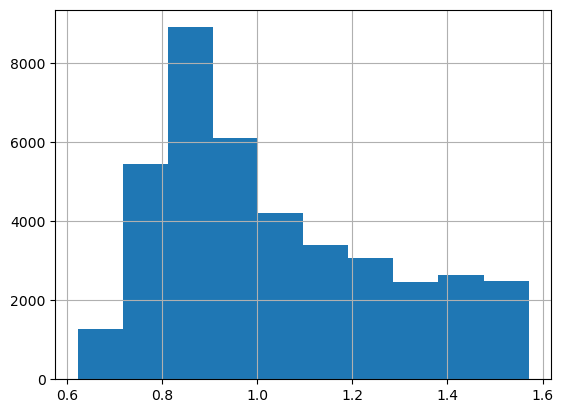

In [107]:
df['theta'].hist()


In [86]:
df['theta'].std()

np.float64(0.23752449521968136)

In [136]:
h=[]
for index, row in df.iterrows():
    xx=np.array(row[['x','y','z']])
    vv=np.array(row[['vx','vy','vz']])
    h.append(np.cross(xx, vv))

In [137]:
dfh=pd.DataFrame(h,columns=['hx','hy','hz'])

In [138]:
dfh

hx        hy        hz
0      0.091306 -0.226804  0.135498
1      0.083002 -0.207841  0.124836
2      0.074007 -0.187422  0.113398
3      0.064330 -0.165561  0.101192
4      0.053984 -0.142285  0.088229
...         ...       ...       ...
19995  0.252057  0.783288  0.543485
19996  0.253737  0.781388  0.542845
19997  0.255874  0.779878  0.542309
19998  0.258509  0.778864  0.541933
19999  0.261682  0.778450  0.541774

[20000 rows x 3 columns]

In [139]:
fig = px.scatter_3d(df,x='x',y='y',z='z')
fig.update_traces(marker={'size': 2})
fig.show()

In [140]:
fig = px.scatter_3d(df,x='hx',y='hy',z='hz')
fig.update_traces(marker={'size': 2})
fig.show()

In [75]:
dfh['hx']

np.float64(-0.03778121210161323)

In [2]:
#!/usr/bin/env python3
"""
Homogeneous ellipsoid interior gravity:
1) Compute ellipsoidal coefficients A_x, A_y, A_z via 1D quadrature
2) Solve interior equations of motion: x¨ + ωx^2 x = 0, etc.
   where ωi^2 = 2π G ρ A_i

Units:
- a,b,c in meters (or any length unit)
- ρ in kg/m^3 (or consistent with G)
- G in SI by default
Time output in seconds.

Dependencies: numpy, scipy
"""

from __future__ import annotations

import numpy as np
from dataclasses import dataclass
from typing import Callable, Tuple

from scipy.integrate import quad, solve_ivp


G_SI = 6.67430e-11  # m^3 kg^-1 s^-2


def _Delta(lam: float, a: float, b: float, c: float) -> float:
    """Δ(λ) = sqrt((a^2+λ)(b^2+λ)(c^2+λ))."""
    return np.sqrt((a * a + lam) * (b * b + lam) * (c * c + lam))


def compute_A_coeffs(a: float, b: float, c: float, *, epsabs: float = 1e-12, epsrel: float = 1e-10
                    ) -> Tuple[float, float, float]:
    """
    Compute (A_x, A_y, A_z) for a homogeneous ellipsoid with semiaxes (a,b,c).

    Definitions:
      A_x = abc ∫_0^∞ dλ / ((a^2+λ) Δ(λ)), etc.

    Notes:
    - A_x + A_y + A_z = 2 (use as a check).
    - For a sphere: A_x = A_y = A_z = 2/3.
    """

    abc = a * b * c

    def integrand_x(lam: float) -> float:
        return abc / ((a * a + lam) * _Delta(lam, a, b, c))

    def integrand_y(lam: float) -> float:
        return abc / ((b * b + lam) * _Delta(lam, a, b, c))

    def integrand_z(lam: float) -> float:
        return abc / ((c * c + lam) * _Delta(lam, a, b, c))

    # quad supports infinite upper limit directly
    Ax, Ax_err = quad(integrand_x, 0.0, np.inf, epsabs=epsabs, epsrel=epsrel, limit=200)
    Ay, Ay_err = quad(integrand_y, 0.0, np.inf, epsabs=epsabs, epsrel=epsrel, limit=200)
    Az, Az_err = quad(integrand_z, 0.0, np.inf, epsabs=epsabs, epsrel=epsrel, limit=200)

    return Ax, Ay, Az


@dataclass
class EllipsoidInteriorDynamics:
    a: float
    b: float
    c: float
    rho: float
    G: float = G_SI
    Ax: float = np.nan
    Ay: float = np.nan
    Az: float = np.nan
    wx2: float = np.nan
    wy2: float = np.nan
    wz2: float = np.nan

    def initialize(self) -> None:
        """Compute A-coefficients and oscillator frequencies."""
        self.Ax, self.Ay, self.Az = compute_A_coeffs(self.a, self.b, self.c)
        self.wx2 = 2.0 * np.pi * self.G * self.rho * self.Ax
        self.wy2 = 2.0 * np.pi * self.G * self.rho * self.Ay
        self.wz2 = 2.0 * np.pi * self.G * self.rho * self.Az

    def rhs(self, t: float, y: np.ndarray) -> np.ndarray:
        """
        State y = [x, y, z, vx, vy, vz].
        Equations:
            xdot = vx
            vxdot = -wx^2 x
        etc.
        """
        x, y_, z, vx, vy, vz = y
        return np.array([
            vx,
            vy,
            vz,
            -self.wx2 * x,
            -self.wy2 * y_,
            -self.wz2 * z
        ], dtype=float)


def solve_trajectory(
    dyn: EllipsoidInteriorDynamics,
    y0: np.ndarray,
    t_span: Tuple[float, float],
    *,
    n_eval: int = 2001,
    rtol: float = 1e-10,
    atol: float = 1e-12,
    method: str = "DOP853",
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Integrate the motion inside the ellipsoid potential.

    Parameters
    ----------
    dyn : EllipsoidInteriorDynamics
        Must be initialized() first.
    y0 : array-like shape (6,)
        Initial condition [x0,y0,z0,vx0,vy0,vz0].
    t_span : (t0, tf)
        Time interval (seconds).
    n_eval : int
        Number of output points.
    """
    y0 = np.asarray(y0, dtype=float).reshape(6)
    t_eval = np.linspace(t_span[0], t_span[1], n_eval)

    sol = solve_ivp(
        fun=dyn.rhs,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        rtol=rtol,
        atol=atol,
        method=method
    )

    if not sol.success:
        raise RuntimeError(f"Integration failed: {sol.message}")

    # return times and states (n_eval, 6)
    return sol.t, sol.y.T


def analytic_solution(
    dyn: EllipsoidInteriorDynamics,
    y0: np.ndarray,
    t: np.ndarray
) -> np.ndarray:
    """
    Closed-form solution (useful for validation):
      x(t) = x0 cos(ωx t) + vx0/ωx sin(ωx t), etc.
    """
    y0 = np.asarray(y0, dtype=float).reshape(6)
    x0, y0_, z0, vx0, vy0, vz0 = y0

    # angular frequencies (handle potential tiny numerical negatives)
    wx = np.sqrt(max(dyn.wx2, 0.0))
    wy = np.sqrt(max(dyn.wy2, 0.0))
    wz = np.sqrt(max(dyn.wz2, 0.0))

    def one_axis(pos0: float, vel0: float, w: float) -> Tuple[np.ndarray, np.ndarray]:
        if w == 0.0:
            # Degenerate: free particle along that axis
            pos = pos0 + vel0 * t
            vel = np.full_like(t, vel0, dtype=float)
        else:
            pos = pos0 * np.cos(w * t) + (vel0 / w) * np.sin(w * t)
            vel = -pos0 * w * np.sin(w * t) + vel0 * np.cos(w * t)
        return pos, vel

    x, vx = one_axis(x0, vx0, wx)
    y_, vy = one_axis(y0_, vy0, wy)
    z, vz = one_axis(z0, vz0, wz)

    Y = np.column_stack([x, y_, z, vx, vy, vz])
    return Y



    

In [3]:
# --- Example usage ---
# Semiaxes (m)
a, b, c = 3.0e6, 2.0e6, 1.5e6   # e.g., triaxial body ~ a few thousand km
# Density (kg/m^3)
rho = 2500.0

dyn = EllipsoidInteriorDynamics(a=a, b=b, c=c, rho=rho)
dyn.initialize()

print("A-coefficients:")
print(f"  Ax = {dyn.Ax:.15f}")
print(f"  Ay = {dyn.Ay:.15f}")
print(f"  Az = {dyn.Az:.15f}")
print(f"  Ax+Ay+Az = {dyn.Ax + dyn.Ay + dyn.Az:.15f}  (should be ~2)")
print("Frequencies (rad/s):")
print(f"  ωx = {np.sqrt(dyn.wx2):.6e}")
print(f"  ωy = {np.sqrt(dyn.wy2):.6e}")
print(f"  ωz = {np.sqrt(dyn.wz2):.6e}")

# Initial conditions (must be inside ellipsoid if you want physical interior motion)
# [x0, y0, z0, vx0, vy0, vz0]
y0 = np.array([0.2*a, 0.1*b, 0.05*c, 0.0, 50.0, 0.0], dtype=float)

# Integrate for some duration
t0, tf = 0.0, 2.0e4  # seconds
t, Y_num = solve_trajectory(dyn, y0=y0, t_span=(t0, tf), n_eval=4001)

# Optional: compare to analytic solution
Y_ana = analytic_solution(dyn, y0=y0, t=t)

max_err = np.max(np.linalg.norm(Y_num - Y_ana, axis=1))
print(f"Max state error vs analytic (sanity check): {max_err:.3e}")

# Example: print final state
print("Final state [x,y,z,vx,vy,vz]:")
print(Y_num[-1])

A-coefficients:
  Ax = -0.000000000000111
  Ay = -0.000000000000250
  Az = -0.000000000000444
  Ax+Ay+Az = -0.000000000000806  (should be ~2)
Frequencies (rad/s):
  ωx = nan
  ωy = nan
  ωz = nan
Max state error vs analytic (sanity check): 3.203e-05
Final state [x,y,z,vx,vy,vz]:
[6.00000000e+05 1.20000000e+06 7.50000000e+04 1.39786212e-09
 5.00000000e+01 6.98931062e-10]


/tmp/ipykernel_3795320/2136266013.py:59: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Ax, Ax_err = quad(integrand_x, 0.0, np.inf, epsabs=epsabs, epsrel=epsrel, limit=200)
/tmp/ipykernel_3795320/2136266013.py:60: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Ay, Ay_err = quad(integrand_y, 0.0, np.inf, epsabs=epsabs, epsrel=epsrel, limit=200)
/tmp/ipykernel_3795320/2136266013.py:61: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Az, Az_err = quad(integrand_z, 0.0, np.inf, epsabs=epsabs, epsrel=epsrel, limit=200)
/tmp/ipykernel_3795320/1294880418.py:16: RuntimeWarning: invalid value encountered in sqrt
  print(f"  ωx = {np.sqrt(dyn.wx2):.6e}")
/tmp/ipykernel_3795320/1294880418.py:17: RuntimeWarning: invalid value encountered in sqrt
  print(f"  ωy = {np.sqrt(dyn.wy2):.6e}")
/tmp/ipykernel_3795320/1294880418.py:18: RuntimeWarning: invalid value encountered in sqrt
  print(f"  ωz = {np.sqrt